In [1]:
import os
import copy
import string
import heapq
import numpy as np
import pandas as pd

from word2number import w2n
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display

import stanza

# FIRST TIME ADD:
# stanza.download('en')

pkg = "ewt"
#pkg = "gum"

depparse_gum_config = {
    'lang': "en",
    'processors': "tokenize,pos,lemma,depparse",
    'tokenize_model_path': '../model/en/tokenize/gum.pt', 
	'pos_model_path': '../model/en/pos/ewt.pt',
    'depparse_model_path': '../model/en/depparse/gum.pt',
    'lemma_model_path': '../model/en/lemma/gum.pt',
    'use_gpu': True,
    'pos_batch_size': 1000
}

depparse_ewt_config = {
    'lang': "en",
    'processors': "tokenize,pos,lemma,depparse",
    'tokenize_model_path': '../model/en/tokenize/gum.pt', 
	'pos_model_path': '../model/en/pos/ewt.pt',
    'depparse_model_path': '../model/en/depparse/ewt.pt',
    'lemma_model_path': '../model/en/lemma/ewt.pt',
    'use_gpu': True,
    'pos_batch_size': 1000
}

token_config = {
    'lang': "en",
    'processors': "tokenize",
    'tokenize_model_path': '../model/en/tokenize/gum.pt', 
    'pos_batch_size': 3000
}

gum_depparse = stanza.Pipeline(**depparse_gum_config)
ewt_depparse = stanza.Pipeline(**depparse_ewt_config)
tokenizer = stanza.Pipeline(**token_config)

2021-03-11 07:14:59 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/gum.pt |
| depparse  | ../model/e...rse/gum.pt  |

2021-03-11 07:14:59 INFO: Use device: gpu
2021-03-11 07:14:59 INFO: Loading: tokenize
2021-03-11 07:15:01 INFO: Loading: pos
2021-03-11 07:15:01 INFO: Loading: lemma
2021-03-11 07:15:01 INFO: Loading: depparse
2021-03-11 07:15:02 INFO: Done loading processors!
2021-03-11 07:15:02 INFO: Loading these models for language: en (English):
| Processor | Package                  |
----------------------------------------
| tokenize  | ../model/e...ize/gum.pt  |
| pos       | ../model/en/pos/ewt.pt   |
| lemma     | ../model/en/lemma/ewt.pt |
| depparse  | ../model/e...rse/ewt.pt  |

2021-03-11 07:15:02 INFO: Use device: gpu
2021-03-11 07:15:02 INFO: Loading: tokenize
2021-03-1

In [2]:
# java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000

replacement = {
    
    "a few": "a-few",
    "a lot of": "a-lot-of",
    "lots of": "lots-of",
    
    "a few of the": "a-few-of-the",
    "none of the": "none-of-the",
    "all of the": "all-of-the",
    "each of the": "each-of-the",
    "some of the": "some-of-the",
    "most of the": "most-of-the",
    "many of the": "many-of-the",
    "several of the": "several-of-the",
    "some but not all": "some-but-not-all",
    "at most": "at-most",
    "at least": "at-least",
    "more than": "more-than",
    "less than": "less-than",
    
    "after all": "after-all",
    "out of": "out-of",
    "hardly ever": "hardly-ever",
    "even if": "even-if",
    "no longer": "no-longer",

    "A few": "A-few",
    "A few of the": "A-few-of-the",
    "None of the": "None-of-the",
    "All of the": "All-of-the",
    "Some of the": "Some-of-the",
    "Most of the": "Most-of-the",
    "Many of the": "Many-of-the",
    "Several of the": "Several-of-the",
    "Some but not all": "Some-but-not-all",
    "At most": "At-most",
    "At least": "At-least",
    "More than": "More-than",
    "Less than": "Less-than",
    "No longer": "No-longer",
    "A lot of": "A-lot-of",
    "Lots of": "Lots-of",
    "Each of the": "Each-of-the",
    "Even if": "Even-if",

    "not every": "not-every",
    "not some": "not-some",
    "not all": "not-all",
    "not each": "not-each",
    "Not every": "Not-every",
    "Not some": "Not-some",
    "Not all": "Not-all",
    "Not each": "Not-each",
}

quantifier_replacement = {
    "a-few": "some",
    "a-few of the": "some",
    "none-of-the": "no",
    "all-of-the": "all",
    "some-of-the": "some",
    "most-of-the": "most",
    "many-of-the": "many",
    "several-of-the": "several",
    "some-but-not-all": "some",
    "at-most": "no",
    "at-least": "some",
    "more-than": "some",
    "less-than": "no",
    "no-longer": "not",
    "a-lot-of": "some",
    "lots-of": "some",
    "each of the": "each",
    "A-few": "Some",
    "A-few of the": "Some",
    "None-of-the": "No",
    "All-of-the": "All",
    "Some-of-the": "Some",
    "Most-of-the": "Most",
    "Many-of-the": "Many",
    "Several-of-the": "Several",
    "Some-but-not-all": "Some",
    "At-most": "No",
    "At-least": "Some",
    "More-than": "Some",
    "Less-than": "No",
    "No-longer": "Not",
    "A-lot-of": "Some",
    "Lots-of": "Some",
    "Each of the": "Each",
    "hardly-ever": "never",
    "Even-if": "If",
    "even-if": "if",
    "not-every": "every",
    "not-some": "some",
    "not-all": "all",
    "not-each": "each",
    "Not-every": "every",
    "Not-some": "some",
    "Not-all": "all",
    "Not-each": "each",

    "after-all": "after-all",
    "out-of": "out-of",
    "hardly-ever": "never",
    "no-longer": "no-longer",
}

def preprocess(sentence):
    replaced = {}
    processed = sentence
    for orig in replacement:
        if orig in processed:
            processed = processed.replace(orig, replacement[orig])
            
    tokens = tokenizer(processed).sentences[0].words
    for tok in tokens:
        if tok.text in quantifier_replacement:
            processed = processed.replace(tok.text, quantifier_replacement[tok.text])
            replaced[str((quantifier_replacement[tok.text], tok.id))] = tok.text 
    
    return processed, replaced

def dependency_parse(sentence, parser="gum"):
    processed, replaced = preprocess(sentence)
    return stanza_parse(processed, parser=parser), replaced

def stanza_parse(sentence, parser="gum"):
    postags = {}
    words = {}
    parse_tree = []
    head_log = {}
    depdent_log = {}

    if parser == "gum":
        parsed = gum_depparse(sentence)
    elif parser == "ewt":
        parsed = ewt_depparse(sentence)

    for sent in parsed.sentences:
        for word in sent.words:
            tree_node = post_process(sent, word, postags, words)

            if len(tree_node) == 0:
                continue

            if tree_node[2] in head_log:
                head_log[tree_node[2]].append(tree_node[0])
            else:
                head_log[tree_node[2]] = [tree_node[0]]

            if tree_node[1] in depdent_log:
                depdent_log[tree_node[1]].append(tree_node[0])
            else:
                depdent_log[tree_node[1]] = [tree_node[0]]

            parse_tree.append(tree_node)

        enhance_parse(parse_tree, head_log, depdent_log, words)
    return parse_tree, postags, words

def enhance_parse(tree, heads, deps, words):
    for node in tree:
        if node[0] == "conj":
            if "nsubj" in heads[node[1]] and "nsubj" in heads[node[2]]:
                node[0] = "conj-sent"
            elif words[node[1]][1] == "JJ" and words[node[2]][1] == "JJ":
                node[0] = "conj-adj"
            elif "NN" in words[node[1]][1] and "NN" in words[node[2]][1]:
                node[0] = "conj-n"
                vp_rel = set(["amod", "compound", "compound",  "compound:prt", "det",
                              "nummod", "appos", "advmod", "nmod", "nmod:poss"])
                vp_left = set(heads[node[1]]) & vp_rel
                vp_right = set(heads[node[2]]) & vp_rel
                if len(vp_left) and len(vp_right):
                    node[0] = "conj-np"
            elif "VB" in words[node[1]][1] and "VB" in words[node[2]][1]:
                node[0] = "conj-vb"
                vp_rel = set(["obj", "xcomp", "obl"])
                vp_left = set(heads[node[1]]) & vp_rel
                vp_right = set(heads[node[2]]) & vp_rel

                if len(vp_left):
                    if len(vp_right):
                        node[0] = "conj-vp"
                    # else:

        if node[0] == "advcl":
            if words[1][0] == "if":
                node[0] = "advcl-sent"
        if node[0] == "advmod":
            if words[node[1]][0] == "not" and node[1] == 1:
                node[0] = "advmod-sent"
        if node[0] == "case" and node[1] - node[2] > 0:
            node[0] = "case-after"
        if words[node[1]][0] in ["at-most", "at-least", "more-than", "less-than"]:
            node[0] = "det"


def post_process(sent, word, postag, words):
    wordID = int(word.id)
    if wordID not in words:
        postag[word.text] = (wordID, word.xpos)
        words[wordID] = (word.text, word.xpos)
    if word.deprel != "punct":
        tree_node = [word.deprel, wordID,
                     word.head if word.head > 0 else "root"]
        return tree_node
    return []


def printTree(tree, tag, word):
    if tree[0] != "root":
        print(f"word: {word[tree[1]][0]}\thead: {word[tree[2]][0]}\tdeprel: {tree[0]}", sep="\n")

In [3]:
class UnifiedCounter:
    def __init__(self, initial_val = 0):
        self.addi_negates = initial_val
        self.unifies = initial_val
        self.nsubjLeft = False
        self.nsubjDetExist = False
        self.expl = False
        self.willing_verb = False
        self.ability_verb = False
        self.allBut = False
        self.atLeastVerb = False
        self.originals = {
                        "nsubjLeft": [False],
                        "nsubjDetExist": [False],
                        "expl": [False],
                        "willing_verb": [False],
                        "ability_verb": [False],
                        "allBut": [False],
                        "atLeastVerb": [False]
        }
    def add_negates(self):
        self.addi_negates += 1 
    def add_unifies(self):
        self.unifies += 1
    def is_unified_clause_subj(self):
        return self.unifies %2 == 1 and self.nsubjLeft

In [4]:
from pqdict import pqdict

class BinaryDependencyTree:
    def __init__(self, val, left, right, key, counter, id=None, pos=None):
        self.val = val
        self.parent = None
        self.left = left
        self.right = right
        self.mark = "0"
        self.id = id
        self.pos = pos
        self.key = key
        self.is_root = False
        self.is_tree = True
        self.length = 0
        self.leaves = pqdict({})
        self.counter = counter
        self.replaced = {}

    def sorted_leaves(self):
        self.traverse(self)
        return self.leaves

    def traverse(self, tree):
        if not tree.is_tree:
            replacement = False
            if str((tree.val, tree.id)) in self.replaced:
                tree.val = self.replaced[str((tree.val, tree.id))]
                replacement = True
            if "-" in tree.val and replacement:
                words = tree.val.split('-')
                words.reverse()
                for i in range(len(words)):
                    word_id = tree.id - i * 0.1
                    key = (words[i], tree.pos, tree.mark, word_id)
                    if words[i].lower() == "not" and len(words) == 2:
                        key = (words[i], tree.pos, negate_mark[tree.mark], word_id)
                    self.leaves[key] = (word_id)
            else:
                item = (tree.id)
                key = (tree.val, tree.pos, tree.mark, tree.id)
                self.leaves[key] = item
        else:
            self.traverse(tree.left)
            self.traverse(tree.right)
            
    def copy(self):
        left = None
        if self.left is not None:
            left = self.left.copy()
        right = None
        if self.right is not None:
            right = self.right.copy()
        new_tree = BinaryDependencyTree(
            self.val, left, right, self.key, self.counter, self.id, self.pos)
        new_tree.mark = self.mark
        new_tree.parent = self.parent
        new_tree.is_tree = self.is_tree
        new_tree.is_root = self.is_root
        new_tree.leaves = pqdict({})
        return new_tree

    def set_length(self, lth):
        self.length = lth

    def set_root(self):
        self.is_root = True

    def set_not_tree(self):
        self.is_tree = False

In [5]:
hierarchy = {
    "conj-sent": 0,
    "advcl-sent": 1,
    "advmod-sent": 2,
    "case": 10,
    "case-after": 75,
    "mark": 10,
    "expl": 10,
    "discourse": 10,
    "nsubj": 20,
    "csubj": 20,
    "nsubj:pass": 20,
    "conj-vp": 25,
    "ccomp": 30,
    "advcl": 30,
    "advmod": 30,
    "nmod": 30,
    "nmod:tmod": 30,
    "nmod:npmod": 30,
    "nmod:poss": 30,
    "xcomp": 40,
    "aux": 40,
    "aux:pass": 40,
    "obj": 60,
    "iobj": 60,
    "obl": 50,
    "obl:tmod": 50,
    "obl:npmod": 50,
    "cop": 50,
    "acl": 60,
    "acl:relcl": 60,
    "appos": 60,
    "conj": 60,
    "conj-np": 60,
    "conj-adj": 60,
    "det": 55,
    "det:predet": 55,
    "cc": 70,
    "nummod": 75,
    "fixed": 80,
    "compound": 80,
    "compound:prt": 80,
    "fixed": 80,
    "amod": 75,
    "conj-n": 90,
    "conj-vb": 90,
    "flat": 100,
    "goeswith": 100,
    "parataxis": 100
}

In [6]:
class Binarizer:
    def __init__(self, parse_table=None, postag=None, words=None):
        self.postag = postag
        self.parse_table = parse_table
        self.words = words
        self.id = 0
        self.counter = UnifiedCounter(0)
        self.replaced = {}

    def process_not(self, children):
        if len(children) > 1:
            if children[0][0] == "advmod":
                if self.words[children[1][1]][0] == "not":
                    return [children[1]]
        return children

    def compose(self, head):
        children = list(filter(lambda x: x[2] == head, self.parse_table))
        children.sort(key=(lambda x: hierarchy[x[0]]))
        children = self.process_not(children)

        if len(children) == 0:
            word = self.words[head][0]
            tag = self.words[head][1]
            binary_tree = BinaryDependencyTree(
                word, None, None, self.id, self.counter, head, tag)
            binary_tree.replaced = self.replaced
            self.id += 1
            binary_tree.set_not_tree()
            return binary_tree, [binary_tree.key]
        else:
            top_dep = children[0]
        self.parse_table.remove(top_dep)

        left, left_rel = self.compose(top_dep[1])
        right, right_rel = self.compose(top_dep[2])
        if "conj" in top_dep[0]:
            dep_rel = "conj"
        elif "case" in top_dep[0]:
            dep_rel = "case"
        elif "advcl" in top_dep[0]:
            dep_rel = "advcl"
        elif "advmod" in top_dep[0]:
            dep_rel = "advmod"
        else:
            dep_rel = top_dep[0]

        binary_tree = BinaryDependencyTree(dep_rel, left, right, self.id, self.counter)
        binary_tree.left.parent = binary_tree
        binary_tree.right.parent = binary_tree
        binary_tree.replaced = self.replaced

        left_rel.append(binary_tree.key)
        self.id += 1
        return binary_tree, left_rel + right_rel

    def binarization(self):
        self.id = 0
        self.relation = []
        root = list(filter(lambda x: x[0] == "root", self.parse_table))[0][1]
        self.counter = UnifiedCounter(0)
        binary_tree, relation = self.compose(root)
        binary_tree.set_root()
        binary_tree.length = len(self.words)
        return binary_tree, relation

In [7]:
from pattern.en import conjugate
import numpy as np

negate_mark = {
    "+": "-",
    "-": "+",
    "=": "="
}

det_mark = {
    "det:univ": "-",
    "det:exist": "+",
    "det:limit": "=",
    "det:negation": "-"
}

det_type_words = {
    "det:univ": ["all", "every", "each", "any", "all-of-the"],
    "det:exist": ["a", "an", "some", "double", "triple", "some-of-the", "al-least", "more-than"],
    "det:limit": ["such", "both", "the", "this", "that",
                  "those", "these", "my", "his", "her",
                  "its", "either", "both", "another"],
    "det:negation": ["no", "neither", "never", "none", "none-of-the", "less-than", "at-most", "few"]
}

negtive_implicative = ["refuse", "reject", "oppose", "forget",
                       "hesitate", "without", "disapprove", "disagree",
                       "eradicate", "erase", "dicline", "eliminate",
                       "decline", "resist", "block", "stop", "hault",
                       "disable", "disinfect", "disapear", "disgard",
                       "disarm", "disarrange", "disallow", "discharge",
                       "disbelieve", "disclaim", "disclose", "disconnect",
                       "disconnect", "discourage", "discredit", "discorporate",
                       "disengage", "disentangle", "dismiss", "disobeye",
                       "distrust", "disrupt", "suspen", "suspend ",
                       "freeze"
                      ]


at_least_implicative = ["for", "buy", "drink", "take", "hold", "receive",
                        "get", "catch", "smoke", "have","give","eat","see"]

exactly_implicative = ["like", "love", "admires", "marry"]

if_verbs = ["see", "understand", "know", "hear", "care"]

willing_verbs = ["want", "ask", "told", "tell", "assign", "force"]
ability_words = ["can", "could","may","might"]

def build_implicative_dict():
    verbs = list(df['Verb'])
    signs = list(df['Signature'])
    implicatives = {}
    for i in range(len(verbs)):
        implicatives[verbs[i]] = signs[i]
    return implicatives

implicatives = {} #build_implicative_dict()
imp_types = {
    '-': negtive_implicative,
    'at_least': at_least_implicative,
    '=': exactly_implicative
}

def is_implicative(word, imp_type):
    verb = conjugate(word, tense="present", person=1, number="singular")
    if imp_type in ['+', '-']:
        if verb in implicatives:
            return implicatives
    return verb in imp_types[imp_type] 

def det_type(word):
    for det in det_type_words:
        if word.lower() in det_type_words[det]:
            return det

arrows = {
    "+": "\u2191",
    "-": "\u2193",
    "=": "=",
    "0": ""
}

arrow2int = {
    "\u2191": 1,
    "\u2193": -1,
    "=": 0
}

def btree2list(binaryDepdency, verbose=0):
    def to_list(tree):
        treelist = []
        if tree.is_tree:
            word = tree.val + arrows[tree.mark]
            if verbose == 2:
                word += str(tree.key)
            treelist.append(word)
        else:
            treelist.append(tree.pos)
            word = tree.val.replace('-', ' ') + arrows[tree.mark]
            if verbose == 2:
                word += str(tree.key)
            treelist.append(word)

        if tree.left is not None:
            treelist.append(to_list(tree.left))

        if tree.right is not None:
            treelist.append(to_list(tree.right))

        return treelist
    return to_list(binaryDepdency)

def annotation2string(annotation):
    annotated = list(annotation['annotated'].popkeys())
    def compose_token(word):
        if '-' in word[0]:
            orig = word[0].split('-')
            return ' '.join([x + arrows[word[2]] for x in orig])
        else:
            return word[0] + arrows[word[2]]
    annotated_sent = ' '.join([compose_token(x) for x in annotated])
    return annotated_sent


def arrow2int(word):
    if arrows['+'] in word:
       return "+"
    elif arrows['-'] in word:
        return "-"
    elif arrows['='] in word:
        return "="

In [8]:
scalar_comparative = {
    "taller": ["+", "-"],
    "lower": ["-", "+"],
    "higher": ["-", "+"],
    "faster": ["+", "-"],
    "slower": ["-", "+"],
    "longer": ["+", "-"],
    "shorter": ["-", "+"],
    "heavier": ["+", "-"],
    "lighter": ["-", "+"],
    "deeper": ["+", "-"],
    "shawlloer": ["-", "+"],
    "brighter": ["+", "-"],
    "darker": ["-", "+"],
    "hotter": ["+", "-"],
    "colder": ["-", "+"],
    "warmer": ["+", "-"],
    "cooler": ["-", "+"],
    "bigger": ["+", "-"],
    "larger": ["+", "-"], 
    "smaller": ["-", "+"],
    "more": ["+", "-"],
    "less": ["-", "+"],
    "fewer": ["-", "+"],
    "greater": ["+", "-"],
    "stronger": ["+", "-"],
    "weaker": ["-", "+"],
    "dryer": ["-", "+"],
    "wetter": ["+", "-"],
    "tigher": ["+", "-"],
    "loose": ["-", "+"],
    "farther": ["+", "-"],
    "closer": ["-", "+"],
}

In [36]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree.ps')
    cf.destroy()
    os.system('convert ../data/tree.ps ../data/tree.png')
    display(Image(filename='../data/tree.png'))
    
def jupyter_draw_rsyntax_tree(tree):
    font_size = '8'
    command = 'rsyntaxtree -s {} "{}"'.format(font_size, tree)
    os.system(command)
    display(Image(filename='./syntree.png'))

In [10]:
class Polarizer:
    def __init__(self, dependtree=None, relation=None):
        self.dependtree = dependtree
        self.sentence_head = []
        self.relation = relation
        self.polarize_function = {
            "acl": self.polarize_acl_relcl,
            "acl:relcl": self.polarize_acl_relcl,
            "advcl": self.polarize_acl_relcl,
            "advmod": self.polarize_advmod,
            "advmod:count": self.polarize_advmod,
            "amod": self.polarize_amod,
            "appos": self.polarize_inherite,
            "aux": self.polarize_aux,
            "aux:pass": self.polarize_aux,
            "case": self.polarize_case,
            "cc": self.polarize_cc,
            "cc:preconj": self.polarize_det,
            "ccomp": self.polarize_ccomp,
            "compound": self.polarize_inherite,
            "compound:prt": self.polarize_inherite,
            "conj": self.polarize_inherite,
            "cop": self.polarize_inherite,
            "csubj": self.polarize_nsubj,
            "csubj:pass": self.polarize_nsubj,
            "dep": self.polarize_dep,
            "det": self.polarize_det,
            "det:predet": self.polarize_det,
            "discourse": self.polarize_inherite,
            "expl": self.polarize_expl,
            "fixed": self.polarize_inherite,
            "flat": self.polarize_inherite,
            "goeswith": self.polarize_inherite,
            "iobj": self.polarize_iobj,
            "mark": self.polarize_inherite,
            "nmod": self.polarize_nmod,
            "nmod:npmod": self.polarize_nmod,
            "nmod:tmod": self.polarize_nmod,
            "nmod:poss": self.polarize_nmod_poss,
            "nsubj": self.polarize_nsubj,
            "nsubj:pass": self.polarize_nsubj,
            "nummod": self.polarize_nummod,
            "obj": self.polarize_obj,
            "obl": self.polarize_obl,
            "obl:npmod": self.polarize_oblnpmod,
            "obl:tmod": self.polarize_inherite,
            "parataxis": self.polarize_inherite,
            "xcomp": self.polarize_obj,
        }
        self.tree_log = []
        self.polar_log = []
        self.replaced = None

        self.DETEXIST = "det:exist"
        self.DETNEGATE = "det:negation"

        self.nsubj_right_equal = False

    def polarize_deptree(self):
        self.polarize(self.dependtree)

    def polarize(self, tree):
        if tree.is_tree:
            self.polarize_function[tree.val](tree)

    def polarize_acl_relcl(self, tree):
        self.sentence_head.append(tree)
        self.right_inheritance(tree)
        right = tree.right
        left = tree.left
        
        verb = self.down_right(tree)
        original_verbState = tree.counter.willing_verb
        if(verb.val.lower() in willing_verbs and left.val == "mark" and left.left.val.lower() == "to"):
            tree.counter.willing_verb = True
    
        if left.is_tree:
            self.polarize(left)
        
        tree.counter.willing_verb = original_verbState
        
        if right.is_tree:
            self.polarize(right)
        
        if right.id == 1:
            right.mark = "-"

        tree.mark = right.mark

        if right.mark == "-" and left.pos != "VBD":
            self.negate(left, -1)
        elif right.mark == "=" and left.pos != "VBD":
            self.equalize(left)
        elif right.val == "impossible":
            self.negate(left, -1)

        self.sentence_head.pop()

    def polarize_advmod(self, tree):
        left = tree.left
        right = tree.right
        self.polarize_inherite(tree)
        root_mark = tree.mark

        if left.val.lower() in ["many", "most"]:
            right.mark = "="
            if isinstance(tree.parent, BinaryDependencyTree) and tree.parent.val == "amod":
                self.equalize(tree.parent.right)
        elif left.val.lower() in ["not", "no", "n't", "never", "rarely", "barely", "seldom"]:
            self.negate(right, -1)
        elif left.val.lower() in ["exactly"]:
            self.equalize(tree.right)
            left.mark = root_mark
            tree.mark = right.mark

        if left.val.lower() == "when":
            self.equalize(self.dependtree)

    def polarize_amod(self, tree):
        left = tree.left
        right = tree.right
        self.polarize_inherite(tree)
        
        
        if left.val.lower() in ["many", "most"]:
            self.equalize(right)
            tree.mark = right.mark
        elif left.val.lower() == "few":
            self.top_down_negate(
                    tree, "amod", self.relation.index(tree.key))
            right.mark = "-"
            self.polarize(right)
        elif self.down_left(tree).val.lower() in ["fewer", "less"]:
            self.noun_mark_replace(right, "-")
            left.mark = "+"
            if(tree.parent.val == "acl:relcl"):
                self.equalize(tree.parent.left)
        elif self.down_left(tree).val.lower() in ["more"]:
            if(tree.parent.val == "acl:relcl"):
                self.equalize(tree.parent.left)
        elif left.val == "advmod":
            if left.right.val == "many":
                self.equalize(right)
                tree.mark = right.mark
            if left.left.val.lower() == "not":
                self.top_down_negate(
                    tree, "amod", self.relation.index(tree.key))
        elif left.val == "out-of":
            if(tree.parent is not None and tree.parent.val == "nummod" and right.val == "nummod"):
                left.mark = "-"
                right.mark =  "+"
                right.right.mark = "+"
                right.left.mark = "="
            self.polarize(right.right)
    
    def polarize_aux(self, tree):
        left = tree.left
        right = tree.right
        tree.counter.originals["ability_verb"].append(tree.counter.ability_verb)
        if left.val in ability_words:
            tree.counter.ability_verb = True
        self.polarize_inherite(tree)
        tree.counter.ability_verb = tree.counter.originals["ability_verb"].pop()
        
    def polarize_case(self, tree):
        self.polarize_inherite(tree)
        right = tree.right
        left = tree.left

        if left.val == "without":
            if right.is_tree:
                self.polarize(right)
            self.negate(tree, self.relation.index(left.key))
        elif right.pos == "CD":
            right.mark = "="
            if left.is_tree:
                self.polarize(left)
        elif right.val == "nmod:poss":
            left.mark = "="
            if right.is_tree:
                self.polarize(right)
        elif left.val == "except":
            right.mark = "="
            if right.is_tree and right.left.val == "for":
                self.nsubj_right_equal = True
        
        ## duration case "for"
        elif left.val.lower() == "for" and right.val == "nummod":
            right.mark = "-"
            self.polarize(right)
        elif left.val == "than":
            temp, changes = self.find_comparative(tree)
            if(temp is not None and changes is not None):
                if(changes[0] != "+"):
                    temp.parent.mark = changes[0]
                    self.polarize(temp.parent)

                if(changes[1] != "+"):
                    right.mark = changes[1]      
                    self.polarize(right)
    def polarize_cc(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left

        if right.val != "expl" and right.val != "det":
            right.mark = tree.mark

        if right.is_tree:
            self.polarize(right)

        if left.val == "but" and not tree.counter.allBut:
            right.mark = "-"
            tree.mark = "-"

        if left.id == 1:
            self.equalize(right)

    def polarize_ccomp(self, tree):
        right = tree.right
        left = tree.left

        if tree.mark != "0":
            right.mark = tree.mark

        if right.is_tree:
            self.polarize(right)

        left.mark = right.mark
        if left.is_tree:
            self.polarize(left)

    def polarize_dep(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left

        if right.is_tree:
            self.polarize(right)

        if left.is_tree:
            self.polarize(left)

    def polarize_det(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left
        
        
        if(tree.counter.willing_verb):
            tree.mark = "="
            left.mark = "="
            self.polarize(left)
            right.mark = "="
            self.polarize(right)
            return
         
        dettype = det_type(left.val)
        if dettype is None:
            dettype = self.DETEXIST

        if left.val.lower() == "any":
            has_roots = isinstance(tree.parent, BinaryDependencyTree)
            has_roots = has_roots and isinstance(tree.parent.parent, BinaryDependencyTree)
            if  has_roots:
                negate_signal = tree.parent.parent.left
                if negate_signal.val == "not":
                    dettype = self.DETEXIST
                if negate_signal.val == "det" and negate_signal.left.val.lower() == "no":
                    dettype = self.DETEXIST
                if tree.counter.addi_negates%2 == 1 :
                    dettype = self.DETEXIST

        detmark = det_mark[dettype]
        right.mark = detmark
        tree.mark = detmark
        
        if(left.val.lower() in det_type_words["det:univ"] and 
           (right.val == "cc" and right.left.val.lower() == "but") and (right.right.val == "nummod")):
            left.mark = "+"
            right.mark = "+"
            right.left.mark = "+"
            right.right.mark = "="
            self.polarize(right.right)
            return
        
        det = str((left.val, left.id))
        at_least = self.replaced.get(det, "det").lower() in ["at-least", "more-than"]
        at_most = self.replaced.get(det, "det").lower() in ["at-most", "less-than"]

        if right.is_tree:
            if right.val == "nummod":
                right.mark = [detmark]
            self.polarize(right)
            if right.val == "nummod":
                if at_least:
                    right.left.mark = "-"
                elif at_most:
                    right.left.mark = "+"
        elif right.pos == 'CD':
            if at_least:
                right.mark = "-"
            elif at_most:
                right.mark = "+"

        if dettype == self.DETNEGATE:
            if(at_most and tree.parent != None and tree.parent.val == "case"):
                self.negate(tree, self.relation.index(tree.key))
            else:
                self.top_down_negate(tree, "det", self.relation.index(tree.key))

        if "not-" in self.replaced.get(det, "det").lower() and len(self.replaced.get(det, "det").lower().split('-')) == 2:
            self.negate(tree.parent, -1)

    def polarize_expl(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left
        
        tree.counter.expl = True
        
        if self.dependtree.left.mark == "-":
            right.mark = "-"

        if left.is_tree:
            self.polarize(left)

        if right.is_tree:
            self.polarize(right)
    def polarize_iobj(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left
        
        if right.is_tree:
            self.polarize(right)
        
        tree.counter.originals["atLeastVerb"].append(tree.counter.atLeastVerb)
        vb = self.down_right(tree)
        
        if is_implicative(vb.val.lower(), 'at_least'):
            tree.counter.atLeastVerb = True
        
        
        if left.val.lower() == "there":
            left.mark = "+"

        if left.is_tree:
            self.polarize(left)
        elif left.val.lower() == "if":
            if(not(tree.parent != None and self.down_right(tree.parent).val in if_verbs)):
                self.negate(right, -1)
        tree.counter.atLeastVerb = tree.counter.originals["atLeastVerb"].pop()
        
    def polarize_nmod(self, tree):
        self.right_inheritance(tree)
        right = tree.right
        left = tree.left

        if right.pos == "DT" or right.pos == "CC":
            detType = det_type(right.val)
            if detType == None:
                detType = self.DETEXIST
            left.mark = det_mark[detType][1]
            if detType == "det:negation":
                self.top_down_negate(
                    tree, "nmod", self.relation.index(tree.key))
        elif right.val.lower() in ["many", "most"]:
            left.mark = "="

        if left.is_tree:
            self.polarize(left)

        if right.is_tree:
            self.polarize(right)

        if left.val == "case":
            if isinstance(tree.parent, BinaryDependencyTree):
                if tree.parent.left.val.lower() == "more":
                    left.right.mark = "-"

        tree.mark = right.mark
        if right.mark == "-":
            if(self.down_left(left).val != "than"):
                self.negate(left, -1)
        elif right.mark == "=":
            if right.left.val != "the":
                self.equalize(left)
            elif right.left.mark == "-":
                self.negate(left, -1)

    def polarize_nmod_poss(self, tree):
        right = tree.right
        left = tree.left

        left.mark = tree.mark
        if left.is_tree:
            self.polarize(left)
        else:
            left.mark = "+"

        right.mark = tree.mark
        if self.search_dependency("det", tree.left):
            right.mark = left.mark
        if right.is_tree:
            self.polarize(right)
        else:
            right.mark = "+"

    def polarize_nsubj(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left
        self.nsubj_right_equal = False

        if self.search_dependency("expl", right):
            self.polarize(left)
            self.polarize(right)
            return
        
        original_DetExist = tree.counter.nsubjDetExist
        all_equal = False
        
        #increment counter
        self.checkNot(tree.right, tree.counter)
        if(self.findDet(tree.left, tree.counter)):
            tree.counter.nsubjDetExist = True
        else:
            subj = self.down_right(tree.left)
            if(subj.pos.lower() == "nns" or subj.pos.lower() == "prp") and self.numNotExist(tree.left):
                tree.counter.nsubjDetExist = True
        
        vb = self.down_right(tree)
        
        if((left.val == "det" and left.left.val.lower() in det_type_words["det:univ"]) 
           and (vb.parent.val == "cc" and vb.parent.left.val.lower() == "but")
           and (left.right.val == "nummod")):
            right.mark = "="
            tree.counter.originals["allBut"].append(tree.counter.allBut)
            tree.counter.allBut = True
            self.polarize(right)
            left.mark = "+"
            left.left.mark = "+"
            left.right.mark = "="
            self.polarize(left.right)
            vb.parent.left.mark = "+"
            tree.counter.allBut = tree.counter.originals["allBut"].pop()
            return
            
        
        
        self.polarize(right)
        tree.counter.nsubjLeft = True
        
        if left.val.lower() == "that":
            self.equalize(right)
        if not tree.is_root:
            if tree.parent.left.val.lower() == "that" and tree.parent.left.mark == "=":
                self.equalize(left)

        if left.is_tree:
            self.polarize(left)
        else:
            if left.val.lower() in ["nobody"]:
                self.negate(tree, self.relation.index(tree.key))

        if tree.mark == "0":
            tree.mark = right.mark

        if left.pos == "NN":
            left.mark = tree.mark

        if is_implicative(right.val.lower(), "-"):
            tree.mark = "-"

        if self.nsubj_right_equal:
            self.equalize(right)
        
        tree.counter.nsubjDetExist = original_DetExist

    def polarize_nummod(self, tree):
        right = tree.right
        left = tree.left
        
        left.mark = "="
        if tree.mark != "0":
            right.mark = tree.mark
            if tree.mark == "-":
                left.mark = "-"
                right.mark = "-"
            elif type(tree.mark) is list:
                right.mark = tree.mark[0]
                tree.mark = right.mark
            elif tree.mark == "--":
                left.mark = "-"
                tree.mark = "+"
            elif not(tree.counter.nsubjDetExist):
                left.mark = "="
                right.mark = "="
            if tree.counter.atLeastVerb or tree.counter.ability_verb:
                if(not(tree.counter.atLeastVerb and tree.counter.ability_verb)):
                    left.mark = negate_mark[tree.mark]
                right.mark = tree.mark
      
                
        else:
            right.mark = "="
        if left.val == "det":
            left.mark = "+"

        if tree.parent == "compound":
            right.mark = left.mark

        if left.is_tree:
            if left.val == "advmod":
                left.mark = "+"
            self.polarize(left)
            if left.mark == "=":
                right.mark = left.mark
                tree.mark = left.mark
        elif left.id == 1:
            left.mark = "="
            """right.mark = "="
            self.nsubj_right_equal = True"""

        if not tree.is_tree:
            if is_implicative(tree.parent.right.val, "-"):
                left.mark = "-"
            elif is_implicative(tree.parent.right.val, "="):
                left.mark = "="
                
        if(tree.counter.willing_verb):
            left.mark = "="
            right.mark = "="
            tree.mark = "="
        
       # if (tree.counter.is_unified_clause_subj() and tree.parent
        if right.is_tree:
            self.polarize(right)
    
    def polarize_obj(self, tree):
        self.right_inheritance(tree)
        right = tree.right
        left = tree.left        
        
        if right.is_tree:
            self.polarize(right)
        
        tree.counter.originals["atLeastVerb"].append(tree.counter.atLeastVerb)
        vb = self.down_right(tree)
        
        if is_implicative(vb.val.lower(), 'at_least'):
            tree.counter.atLeastVerb = True
        
        if tree.counter.atLeastVerb and tree.counter.ability_verb:
                left.mark = "-"
                
        if left.is_tree:
            self.polarize(left)

        tree.counter.atLeastVerb = tree.counter.originals["atLeastVerb"].pop()
      
        if is_implicative(right.val.lower(), "-"):
            tree.mark = "-"
            self.negate(left, -1)
        
            
        
        if left.val == "mark" and left.left.val == "to":
            left.left.mark = right.mark

    def polarize_obl(self, tree):
        self.right_inheritance(tree)
        right = tree.right
        left = tree.left

        scalar_arrow = "+"
        if right.is_tree:
            self.polarize(right)
            try:
                scalar_arrow = scalar_comparative[right.left.val][1]
            except KeyError:
                 pass
        else:
            try:
                scalar_arrow = scalar_comparative[right.val][1]
            except KeyError:
                 pass

        if left.is_tree:
            self.polarize(left)
            if left.right.val == "nummod":
                if(left.right.left.mark != "-"):
                    left.right.left.mark = scalar_arrow
            elif left.right.pos == "CD":
                left.right.mark = scalar_arrow

        if right.mark == "-":
            self.negate(left, -1)

    def polarize_oblnpmod(self, tree):
        right = tree.right
        left = tree.left

        if left.is_tree:
            self.polarize(left)
        right.mark = left.mark
        if right.is_tree:
            self.polarize(right)

    def polarize_inherite(self, tree):
        self.full_inheritance(tree)
        right = tree.right
        left = tree.left

        if right.is_tree:
            self.polarize(right)

        if left.val.lower() == "there":
            left.mark = "+"

        if left.is_tree:
            self.polarize(left)
        elif left.val.lower() == "if":
            if(not(tree.parent != None and self.down_right(tree.parent).val in if_verbs)):
                self.negate(right, -1)

    def search_dependency(self, deprel, tree):
        if tree.val == deprel:
            return True
        else:
            right = tree.right
            left = tree.left

            left_found = False
            right_found = False

            if right is not None and right.is_tree:
                right_found = self.search_dependency(deprel, right)

            if left is not None and left.is_tree:
                left_found = self.search_dependency(deprel, left)

            return left_found or right_found
        
    def checkNot(self, tree, counter):
        if(tree.right == None or tree.val != "advmod"):
            return
        else:
            if(tree.val == "advmod" and tree.left.val in ["not", "n't"]):
                tree.counter.add_negates()
            return self.checkNot(tree.right, counter)
            
    def findDet(self, tree, counter):
        if(tree.right == None):
            return False
        else:
            if(tree.val in ["det", "amod"] and tree.left.val.lower() in det_type_words["det:negation"]):
                counter.add_negates()
                self.findDet(tree.right, counter)
                return True
            elif(tree.val in ["det"] and tree.left.val.lower() in det_type_words["det:univ"]):
                counter.add_unifies()
                self.findDet(tree.right, counter)
                return True
            elif(tree.val in ["det"] and tree.left.val.lower() in det_type_words["det:exist"]):
                self.findDet(tree.right, counter)
                return True
            else:
                return self.findDet(tree.right, counter)

    def numNotExist(self, tree):
        if(tree.right == None):
            return True
        else:
            if(tree.val == "nummod"):
                return False
            return self.numNotExist(tree.right)
        
    def down_left(self,tree):
        if(tree.left == None):
            return tree
        return self.down_left(tree.left)
               
    def down_right(self, tree):
        if(tree.right == None):
            return tree
        return self.down_right(tree.right)
               
    def find_comparative(self, tree):
        parent = tree.parent
        
      
        #if(parent.val == "nmod"):
        #    target = parent.right
        #elif(parent.val == "obl"):
        #    target = parent.right
        modified, comp = self.find_right(parent, "amod")
        if(modified is None):
            return None, None
        return modified, scalar_comparative[comp.val.lower()] 
    
    def find_right(self, tree, val):
        if(tree.right is None):
            return None, None
        if(tree.val == val):
            comp = self.down_left(tree)
            if comp.val.lower() in scalar_comparative:
                return tree, comp
            return self.find_right(tree.right, val)
        return self.find_right(tree.right, val)

    def find_comp_modifying(self, tree):
        if(tree.val == "amod"):
            return tree.right
        if(tree.is_root):
            return None
        return self.find_comp_modifying(tree.parent)
    
    def noun_mark_replace(self, tree, mark):
        if isinstance(tree, str):
            return False
        if tree.pos is not None and "NN" in tree.pos:
            tree.mark = mark
            return True
        right = self.noun_mark_replace(tree.right, mark)
        if not right:
            self.noun_mark_replace(tree.left, mark)

    def right_inheritance(self, tree):
        if tree.mark != "0":
            tree.right.mark = tree.mark
        else:
            tree.right.mark = "+"
            tree.mark = "+"
        tree.left.mark = "+"

    def full_inheritance(self, tree):
        if tree.mark != "0":
            tree.right.mark = tree.mark
            tree.left.mark = tree.mark
        else:
            tree.right.mark = "+"
            tree.left.mark = "+"
            tree.mark = "+"

    def equalize(self, tree):
        if tree.is_tree:
            self.equalize(tree.right)
            self.equalize(tree.left)
            if tree.mark != "0":
                tree.mark = "="
        else:
            if tree.pos != "CC" and tree.val.lower() != "when":
                tree.mark = "="

    def negate_condition(self, tree, anchor):
        not_truth_connection = not tree.val in ["and", "or"]
        not_empty_mark = tree.mark != "0"
        return not_empty_mark and not_truth_connection

    def top_down_negate(self, tree, deprel, anchor):
        if not isinstance(tree.parent, BinaryDependencyTree):
            return
        if tree.parent.left.val == deprel:
            self.negate(tree.parent.left, anchor)
            self.negate(tree.parent.right, -1)
        elif tree.parent.right.val == deprel:
            self.negate(tree.parent.right, anchor)
            self.negate(tree.parent.left, -1)

    def negate(self, tree, anchor):
        if isinstance(tree, str):
            return
        if tree.val == "cc" and tree.right.val in ["expl", "nsubj", "det"]:
            return
        if tree.val == "mark" and tree.left.val.lower() == "if" and tree.left.id < 3:
            return
        if tree.is_tree:
            # print(tree.val)
            if self.relation.index(tree.key) > anchor or "nsubj" in tree.val:
                # print(tree.val)
                self.negate(tree.right, anchor)
                self.negate(tree.left, anchor)
                if self.negate_condition(tree, anchor):
                    tree.mark = negate_mark[tree.mark]
        else:
            if self.relation.index(tree.key) > anchor and self.negate_condition(tree, anchor):
                if tree.pos != "EX":
                    # print(tree.val)
                    tree.mark = negate_mark[tree.mark]
                


In [11]:
import svgling

class PolarizationPipeline:
    def __init__(self, sentences=None, verbose=0, parser="gum"):
        self.binarizer = Binarizer()
        self.polarizer = Polarizer()
        self.annotations = []
        self.annotated_sentences = []
        self.exceptioned = []
        self.incorrect = []
        self.verbose = verbose
        self.parser = parser
        self.sentences = sentences
        self.num_sent = 0 if sentences is None else len(sentences)

    def run_binarization(self, parsed, replaced, sentence):
        self.binarizer.parse_table = parsed[0]
        self.binarizer.postag = parsed[1]
        self.binarizer.words = parsed[2]

        if self.verbose == 2:
            print()
            print(parsed[0])
            print()
            print(parsed[1])
            print()
            print(replaced)

        self.binarizer.replaced = replaced
        binary_dep, relation = self.binarizer.binarization()
        if self.verbose == 2:
            self.postprocess(binary_dep)
        return binary_dep, relation

    def postprocess(self, tree, svg=False):
        sexpression = btree2list(tree, 0)
        if not svg:
            sexpression = '[%s]' % ', '.join(
                map(str, sexpression)).replace(",", " ").replace("'", "")
        #print(sexpression)
        return sexpression

    def run_polarization(self, binary_dep, relation, replaced, sentence):
        self.polarizer.dependtree = binary_dep
        self.polarizer.relation = relation
        self.polarizer.replaced = replaced

        self.polarizer.polarize_deptree()
        if self.verbose == 2:
            self.postprocess(binary_dep)
        elif self.verbose == 1:
            polarized = self.postprocess(binary_dep)
            svgling.draw_tree(polarized)
            #jupyter_draw_rsyntax_tree(polarized)
            #btreeViz = Tree.fromstring(polarized.replace('[', '(').replace(']', ')'))
            #jupyter_draw_nltk_tree(btreeViz) 
    
    def modify_replacement(self, tree, replace):
        if str((tree.val,tree.id)) in replace:
            tree.val = replace[str((tree.val,tree.id))]
        
        if tree.is_tree:
            self.modify_replacement(tree.left, replace)
            self.modify_replacement(tree.right, replace)

    def single_polarization(self, sentence):
        parsed, replaced = dependency_parse(sentence, self.parser)
        #print(parsed)
        binary_dep, relation = self.run_binarization(
            parsed, replaced, sentence)
        #print(parsed)
        self.run_polarization(binary_dep, relation, replaced, sentence)
        annotated = self.polarizer.dependtree.sorted_leaves()

        if self.verbose == 2:
            annotated_sent = ' '.join([word[0] for word in annotated.keys()])
            self.annotated_sentences.append(annotated_sent)

        self.modify_replacement(self.polarizer.dependtree, replaced)

        return {
            'original': sentence,
            'annotated': annotated,
            'polarized_tree': self.polarizer.dependtree,
        }

    def batch_polarization(self, sentences):
        for i in tqdm(range(self.num_sent)):
            sent = sentences[i]
            try:
                annotation = self.single_polarization(sent)
                self.annotations.append(annotation)
            except Exception as e:
                if self.verbose == 2:
                    print(str(e))
                self.exceptioned.append(sent)


In [28]:
from svgling.figure import Caption, SideBySide, RowByRow

# test comparative numerical inference              
sentences = ["John is less than 2 years older",
             "A Number 5 is greater than 4", 
             "The exam is shorter than 5 hours",
             "New York has more buildings than Dallas",
             "There are some amazing hikes around Mt Fuji"]

pipeline = PolarizationPipeline(verbose=0)

tree_visuals = []
for sentence in sentences:
    annotation = pipeline.single_polarization(sentence)
    print(list(zip(*annotation['annotated'].popkeys()))[2])
    #tree = pipeline.postprocess(annotation["polarized_tree"])
    #btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    #tree_visuals.append(svgling.draw_tree(tree1))
    #jupyter_draw_nltk_tree(btree)
#RowByRow(tree_visuals[0], tree_visuals[1], tree_visuals[2], tree_visuals[3], tree_visuals[4])


('+', '+', '+', '+', '+', '-', '-')
('+', '+', '+', '+', '+', '+', '-')
('+', '=', '+', '+', '+', '+', '=')
('+', '+', '+', '+', '+', '+', '-')
('+', '+', '+', '+', '+', '+', '+', '+')



[['nsubj', 1, 7], ['cc', 2, 3], ['conj-n', 3, 1], ['aux', 5, 7], ['advmod', 6, 7], ['root', 7, 'root'], ['amod', 8, 9], ['obj', 9, 7], ['advmod', 10, 7]]

{'Tom': (1, 'NNP'), 'and': (2, 'CC'), 'John': (3, 'NNP'), ',': (4, ','), 'do': (5, 'VBP'), 'not': (6, 'RB'), 'eat': (7, 'VB'), 'fresh': (8, 'JJ'), 'meat': (9, 'NN'), 'anymore': (10, 'RB')}

{}


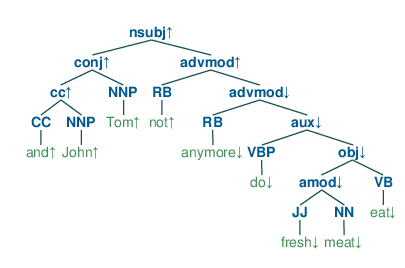

('+', '+', '+', '-', '+', '-', '-', '-', '-')


In [43]:
sentences = ["Tom and John, do not eat fresh meat anymore"]
pipeline = PolarizationPipeline(verbose=2)
for sentence in sentences:
    annotation = pipeline.single_polarization(sentence)
    tree = pipeline.postprocess(annotation["polarized_tree"])
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)
    print(list(zip(*annotation['annotated'].popkeys()))[2])

In [20]:
arrow_num = {
    "+": 1,
    "-": -1,
    "=": 0
}

polarity_gold = pd.read_csv("Udep2Mono/polarity_gold.csv")
gold = zip(polarity_gold['Sentence'].tolist(), polarity_gold['Polarity'].tolist())

num_tok = 0
num_key_tok = 0
num_correct = 0
num_correct_tok = 0
num_correct_key_tok = 0
y_pred = []
y_true = []
y_pred_key = []
y_true_key = []
postags = []
pipeline = PolarizationPipeline(verbose=0, parser="gum")
for sentence in gold:
    annotation = pipeline.single_polarization(sentence[0])
    #tree = pipeline.postprocess(annotation["polarized_tree"],[])
    #btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    #jupyter_draw_nltk_tree(btree)
    annotate_info = list(zip(*annotation['annotated'].popkeys()))
    pred_arrows = annotate_info[2]
    label_arrows = sentence[1].split(' ')
    predicted = [arrow_num[x] for x in pred_arrows]
    label = [arrow_num[x] for x in label_arrows]
    x = np.array(predicted)
    y = np.array(label)
    y_pred += list(x)
    y_true += list(y)
    num_tok += len(y)
    pos = annotate_info[1]
    postags.append(pos)
    for i in range(len(pos)):
        if 'NN' in pos[i] or 'VB' in pos[i] or 'JJ' in pos[i] or 'DT' in pos[i] or 'CD' in pos[i]:
            y_pred_key.append(x[i])
            y_true_key.append(y[i])
            if x[i] == y[i]:
                num_correct_key_tok += 1
            num_key_tok += 1
    if np.array_equal(x, y):
        num_correct += 1
        num_correct_tok += len(y)
    else:
        for i in range(len(predicted)):
            if predicted[i] == label[i]:
                num_correct_tok += 1
        print(sentence[0])
        list_pred = list(pred_arrows)
        sent_list = sentence[0].split(" ")
        for i in range(len(sent_list)):
            list_pred[i] = sent_list[i] + list_pred[i]
            label_arrows[i] = sent_list[i] + label_arrows[i] 
        print("Udep2Mono: ")
        print(list_pred)
        print("Suggested Solution: ")
        print(label_arrows)

print("Sentence Accuracy: ", num_correct*100/56)
print("Number of tokens: ", num_tok)
print("All-token Accuracy: ", num_correct_tok*100/num_tok)
print("Number of key tokens: ", num_key_tok)
print("Key-token Accuracy: ", num_correct_key_tok*100/num_key_tok)

There is a dog in the house who wants to eat three biscuits
Udep2Mono: 
['There+', 'is+', 'a+', 'dog+', 'in+', 'the+', 'house=', 'who=', 'wants=', 'to=', 'eat=', 'three=', 'biscuits=']
Suggested Solution: 
['There+', 'is+', 'a+', 'dog+', 'in+', 'the+', 'house=', 'who+', 'wants+', 'to+', 'eat+', 'three=', 'biscuits=']
Five dogs see at least six cats
Udep2Mono: 
['Five=', 'dogs=', 'see+', 'at+', 'least+', 'six-', 'cats+']
Suggested Solution: 
['Five+', 'dogs=', 'see=', 'at=', 'least=', 'six=', 'cats=']
No dentist who recommends that their patients brush their teeth at least four times a day gave five patients a toothbrush
Udep2Mono: 
['No+', 'dentist-', 'who-', 'recommends-', 'that-', 'their-', 'patients-', 'brush-', 'their-', 'teeth-', 'at-', 'least-', 'four+', 'times-', 'a-', 'day-', 'gave-', 'five+', 'patients-', 'a-', 'toothbrush-']
Suggested Solution: 
['No+', 'dentist-', 'who-', 'recommends-', 'that-', 'their-', 'patients-', 'brush-', 'their-', 'teeth-', 'at-', 'least-', 'four-', '

In [21]:
from sklearn import metrics
print(metrics.confusion_matrix(y_true, y_pred))
print(metrics.classification_report(y_true, y_pred, digits=3))
print(metrics.confusion_matrix(y_true_key, y_pred_key))
print(metrics.classification_report(y_true_key, y_pred_key, digits=3))

[[164   0   2]
 [  4  55   4]
 [  2   5 245]]
              precision    recall  f1-score   support

          -1      0.965     0.988     0.976       166
           0      0.917     0.873     0.894        63
           1      0.976     0.972     0.974       252

    accuracy                          0.965       481
   macro avg      0.952     0.944     0.948       481
weighted avg      0.964     0.965     0.964       481

[[133   0   2]
 [  4  49   4]
 [  1   3 189]]
              precision    recall  f1-score   support

          -1      0.964     0.985     0.974       135
           0      0.942     0.860     0.899        57
           1      0.969     0.979     0.974       193

    accuracy                          0.964       385
   macro avg      0.958     0.941     0.949       385
weighted avg      0.963     0.964     0.963       385



In [22]:
with open('gold.polarized.txt', 'r', encoding='utf-8') as ccg2mono:
    output = ccg2mono.readlines()
    num_tok = 0
    num_key_tok = 0
    num_correct = 0
    num_correct_tok = 0
    num_correct_key_tok = 0
    y_pred = []
    y_true = []
    y_pred_key = []
    y_true_key = []
    
    gold_labels = list(zip(polarity_gold['Sentence'].tolist(), polarity_gold['Polarity'].tolist()))
    for j in range(len(output)):

        pred_arrows = []
        for token in output[j]:
            if "\u2191" in token:
                pred_arrows.append('+')
            elif "\u2193" in token:
                pred_arrows.append('-')
            elif "=" in token:
                pred_arrows.append('=')
        label_arrows = gold_labels[j][1].split(' ')
        predicted = [arrow_num[x] for x in pred_arrows]
        label = [arrow_num[x] for x in label_arrows]
        x = np.array(predicted)
        y = np.array(label)

        y_pred += list(x)
        y_true += list(y)
        
        num_tok += len(y)
        pos = postags[j]
        for i in range(len(pos)):
            if 'NN' in pos[i] or 'VB' in pos[i] or 'JJ' in pos[i] or 'DT' in pos[i] or 'CD' in pos[i]:
                y_pred_key.append(x[i])
                y_true_key.append(y[i])
                if x[i] == y[i]:
                    num_correct_key_tok += 1
                num_key_tok += 1
        if np.array_equal(x, y):
            num_correct += 1
            num_correct_tok += len(y)
        else:
            for i in range(len(predicted)):
                if predicted[i] == label[i]:
                    num_correct_tok += 1

print("Sentence Accuracy: ", num_correct*100/56)
print("Number of tokens: ", num_tok)
print("All-token Accuracy: ", num_correct_tok*100/num_tok)
print("Number of key tokens: ", num_key_tok)
print("Key-token Accuracy: ", num_correct_key_tok*100/num_key_tok)

Sentence Accuracy:  50.0
Number of tokens:  481
All-token Accuracy:  77.54677754677755
Number of key tokens:  385
Key-token Accuracy:  78.96103896103897


In [23]:
print(metrics.confusion_matrix(y_true, y_pred))
print(metrics.classification_report(y_true, y_pred, digits=3))
print(metrics.confusion_matrix(y_true_key, y_pred_key))
print(metrics.classification_report(y_true_key, y_pred_key, digits=3))

[[130  13  23]
 [  7  47   9]
 [ 35  21 196]]
              precision    recall  f1-score   support

          -1      0.756     0.783     0.769       166
           0      0.580     0.746     0.653        63
           1      0.860     0.778     0.817       252

    accuracy                          0.775       481
   macro avg      0.732     0.769     0.746       481
weighted avg      0.787     0.775     0.779       481

[[107   9  19]
 [  7  42   8]
 [ 22  16 155]]
              precision    recall  f1-score   support

          -1      0.787     0.793     0.790       135
           0      0.627     0.737     0.677        57
           1      0.852     0.803     0.827       193

    accuracy                          0.790       385
   macro avg      0.755     0.778     0.765       385
weighted avg      0.796     0.790     0.792       385



In [26]:
arrow_num = {
    "+": 1,
    "-": -1,
    "=": 0
}
with open('natlog.txt', 'r', encoding='utf-8') as natlog:
    output = natlog.readlines()
    num_tok = 0
    num_key_tok = 0
    num_correct = 0
    num_correct_tok = 0
    num_correct_key_tok = 0
    y_pred = []
    y_true = []
    y_pred_key = []
    y_true_key = []
    
    gold_labels = list(zip(polarity_gold['Sentence'].tolist(), polarity_gold['Polarity'].tolist()))
    for j in range(len(output)):
        pred_arrows = output[j].replace('[','').replace(']','').replace('\n','').replace(' ','').split(',')
        label_arrows = gold_labels[j][1].split(' ')
        predicted = [arrow_num[x] for x in pred_arrows]
        label = [arrow_num[x] for x in label_arrows]
        x = np.array(predicted)
        y = np.array(label)

        y_pred += list(x)
        y_true += list(y)
        
        num_tok += len(y)
        pos = postags[j]
        for i in range(len(pos)):
            if 'NN' in pos[i] or 'VB' in pos[i] or 'JJ' in pos[i] or 'DT' in pos[i] or 'CD' in pos[i]:
                y_pred_key.append(x[i])
                y_true_key.append(y[i])
                if x[i] == y[i]:
                    num_correct_key_tok += 1
                num_key_tok += 1
        if np.array_equal(x, y):
            num_correct += 1
            num_correct_tok += len(y)
        else:
            for i in range(len(predicted)):
                if predicted[i] == label[i]:
                    num_correct_tok += 1

print("Sentence Accuracy: ", num_correct*100/56)
print("Number of tokens: ", num_tok)
print("All-token Accuracy: ", num_correct_tok*100/num_tok)
print("Number of key tokens: ", num_key_tok)
print("Key-token Accuracy: ", num_correct_key_tok*100/num_key_tok)

Sentence Accuracy:  28.571428571428573
Number of tokens:  481
All-token Accuracy:  69.85446985446985
Number of key tokens:  385
Key-token Accuracy:  68.05194805194805


In [25]:
print(metrics.confusion_matrix(y_true, y_pred))
print(metrics.classification_report(y_true, y_pred, digits=3))
print(metrics.confusion_matrix(y_true_key, y_pred_key))
print(metrics.classification_report(y_true_key, y_pred_key, digits=3))

[[106   6  54]
 [ 19  10  34]
 [ 25   7 220]]
              precision    recall  f1-score   support

          -1      0.707     0.639     0.671       166
           0      0.435     0.159     0.233        63
           1      0.714     0.873     0.786       252

    accuracy                          0.699       481
   macro avg      0.619     0.557     0.563       481
weighted avg      0.675     0.699     0.674       481

[[ 83   6  46]
 [ 17   8  32]
 [ 17   5 171]]
              precision    recall  f1-score   support

          -1      0.709     0.615     0.659       135
           0      0.421     0.140     0.211        57
           1      0.687     0.886     0.774       193

    accuracy                          0.681       385
   macro avg      0.606     0.547     0.548       385
weighted avg      0.655     0.681     0.650       385



In [13]:
sentences = [["There is a dog in the house who wants to eat three biscuits", 
              ['+', '+', '+', '+', '+', '+', '=', '+', '+', '+', '+', '=', '=']]]
pipeline = PolarizationPipeline(verbose=0, parser="ewt")
for sentence in sentences:
    print(sentence[0])
    annotation = pipeline.single_polarization(sentence[0])
    #tree = pipeline.postprocess(annotation["polarized_tree"])
    #btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    #jupyter_draw_nltk_tree(btree)
    print(list(zip(*annotation['annotated'].popkeys()))[2])
    print(sentence[1])
    

There is a dog in the house who wants to eat three biscuits
('+', '+', '+', '+', '+', '+', '=', '+', '+', '+', '+', '-', '+')
['+', '+', '+', '+', '+', '+', '=', '+', '+', '+', '+', '=', '=']


In [ ]:
sentences = ["All the cats, except for at most two, eat chocolate",
             "All the cats except for two, love to run",
             "All students except engineers must take a class in Organic Chemistry",
             "At most 6 dogs are hungry",
             "At least 5 people ran",
             "Less than 5 people ran",
             "More than 6 dogs are hungry",
             "Exactly 8 cats are sleeping", 
             "A dog ate 2 rotten biscuits",
             "Some but not all students cheated in this class",
             "More than three students cheated in this class",
             "Less than five students got A in the class",
             "Every dog who likes most cats was chased by at least two of them",
             "Some person in the White House doesn't know if any dog in Ohio ate bananas yesterday",
             "No dentist who recommends that their patients brush their teeth at least four times a day gave five patients a toothbrush"]
pipeline = PolarizationPipeline(verbose=0)
for sentence in sentences:
    print(sentence)
    annotation = pipeline.single_polarization(sentence)
    tree = pipeline.postprocess(annotation["polarized_tree"])
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)
    print(list(zip(*annotation['annotated'].popkeys()))[2])

In [ ]:
baseline = ["All dogs run", "Some dogs run", "No dog runs", 
            "All dogs eat apples", "Some dogs eat apples", "No dog eats apples", "That dog eats apples",
            "Many dogs sleep at night. ", "Most dogs sleep at night. ", "A few dogs sleep at night. ",
            "At least 5 dogs sleep at night. ", "At most five dogs eat dinner.","Five dogs are chasing cats",
            "All beautiful dogs eat apples", 
            "Some beautiful dogs eat apples", 
            "No beautiful dogs eat apples", 
            "All beautiful and smart dogs eat apples", 
            "No beautiful and smart dogs eat apples",
            "Some beautiful and smart dogs eat apples",
            "A smart and healthy person sleeps at night",
            "Every smart and healthy people sleep at night",
            "That tall and beautiful flower opens at night",
            "A man is playing the piano happily",
            "Every dog is excitedly chasing some cats",
            "No dog is excitedly chasing some cats",
            "All books here are beautifully printed and absolutely immaculate"]
            
Conservativity = ["No really great tenors are modest", "Some Italian tenors are great", 
                  "The really ambitious tenors are Italian", "Each Italian tenors wants to be great",
     ho wants to eat three biscuit", ['+', '+', '+', '+', '+', '+', '=', '+', '+', '+', '+', '=', '=']],
    ["Few math students love any subject in linguistics", ['+', '-', '-', '-', '-', '-', '-', '-']],
    ["Five dogs see at least six cats", ['+', '=', '=', '=', '=', '=', '=']],
    ["Every cat who no dog chases, rests", ['+', '-', '+', '-', '+', '+', '+']],
    ["Every dog who likes most cats was chased by at least two of them", ['+', '-', '-', '-', '-', '=', '+', '+', '+', '+', '+', '-', '+', '+']],
    ["More dogs than cats sit", ['+', '+', '+', '-', '=']],
    ["Fewer dogs than cats sit", ['+', '-', '+', '+', '=']],
    ["Every student's favorite class was French", ['+', '-', '-', '-', '-', '+', '+']],
    ["No students liked any class in Chemistry", ['+', '-', '-', '-', '-', '-', '-']],
    ["All but five dogs died", ['+', '+', '=', '=', '=']],
    ["Three out of five dentists recommend that their patients brush their teeth at least four times a day", ['=', '-', '-', '=', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+', '-', '+', '+', '+']],
    ["No dentist who recommends that their patients brush their teeth at least four times a day gave five patients a toothbrush", ['+', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-']],
    ["Every doctor who told her patients to take three pills a day was afraid that taking four or more would kill them", ['+', '-', '-', '-', '-', '-', '-', '-', '=', '=', '=', '=', '+', '+', '+', '+', '+', '+', '+', '+', '+', '+']],
    ["My parents said I could have three candies", ['+', '+', '+', '+', '+', '+', '=', '+']],
    ["If you are addicted to cigarettes, you can smoke two a day", ['+', '-', '-', '-', '-', '-', '+', '+', '+', '-', '+', '+']],
    ["Even if you are addicted to cigarettes, you can smoke two a day", ['+', '+', '-', '-', '-', '-', '-', '+', '+', '+', '-', '+', '+']],
    ["Every person who smokes two cigarettes in one hour runs a risk of cancer", ['+', '-', '-', '-', '+', '-', '+', '-', '-', '+', '+', '+', '+', '+']],
    ["If every cat runs, some dog runs also", ['+', '-', '+', '-', '+', '+', '+', '+']],
    ["If some dog runs, no cat sits", ['+', '-', '-', '-', '+', '-', '-']],
    ["A dog who ate two rotten biscuits was sick for three days", ['+', '+', '+', '+', '=', '+', '+', '+', '+', '+', '-', '-']],
    ["John is dancing without clothes", ['+', '+', '+', '+', '-']],
    ["Ursula refused to sing or dance", ['+', '+', '+', '-', '+', '-']],
    ["A dog ate 2 rotten biscuits", ['+', '+', '+', '=', '+', '+']],
    ["Any dog in Michigan would prefer to live in Indiana", ['+', '-', '-', '-', '+', '+', '+', '+', '+', '+']],
    ["All the cats, except for at most two, eat chocolate", ['+', '-', '=', '-', '-', '-', '-', '-', '=', '=']],
    ["All the cats except for two, love to run", ['+', '-', '=', '-', '-', '=', '=', '=', '=']],
    ["All students except engineers must take a class in Organic Chemistry", ['+', '-', '-', '=', '+', '+', '+', '+', '+', '+', '+']],
    ["At least seven fish died yesterday in Morocco", ['+', '+', '-', '+', '+', '+', '+', '+']],
    ["At most 6 dogs are hungry", ['+', '+', '+', '-', '-', '-']],
    ["At least 5 people ran", ['+', '+', '-', '+', '+']],
    ["Less than 5 people ran", ['+', '+', '+', '-', '-']],
    ["More than 6 dogs are hungry", ['+', '+', '-', '+', '+', '+']],
    ["Exactly 8 cats are sleeping", ['+', '=', '=', '=', '=']],
    ["Some but not all students cheated in this class", ['+', '+', '+', '+', '+', '+', '+', '+', '=']],
    ["More than three students cheated in this class", ['+', '+', '-', '+', '+', '+', '+', '=']],
    ["Less than five students got A in the class", ['+', '+', '+', '-', '-', '-', '-', '-', '=']]
]

In [ ]:
data = [[g[0], ' '.join(g[1])] for g in gold]

df = pd.DataFrame(data, columns=['Sentence', 'Polarity'])
df.to_csv("Udep2Mono/polarity_gold.csv")

In [ ]:
monotonicity_up_first = [
    "A Swede won a Nobel prize.",
    "Every Swede is a Scandinavian.",
    "A Scandinavian won a Nobel prize.",
    "Every Canadian resident can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "Every resident of the North American continent can travel freely within Europe.",
    "All Canadian residents can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "All residents of the North American continent can travel freely within Europe.",
    "Each Canadian resident can travel freely within Europe.",
    "Every Canadian resident is a resident of the North American continent.",
    "Each resident of the North American continent can travel freely within Europe.",
    "The residents of major western countries can travel freely within Europe.",
    "All residents of major western countries are residents of western countries.",
    "The residents of western countries have the right to live in Europe.",
    "No Scandinavian delegate finished the report on time.",
    "Some delegate finished the report on time.",
    "Some Irish delegates finished the survey on time.",
    "Some delegates finished the survey on time.",
    "Many British delegates obtained interesting results from the survey.",
    "Many delegates obtained interesting results from the survey.",
    "Several Portuguese delegates got the results published in major national newspapers.",
    "Several delegates got the results published in major national newspapers.",
    "Most Europeans who are resident in Europe can travel freely within Europe.",
    "Most Europeans can travel freely within Europe.",
    "A few female committee members are from Scandinavia.",
    "At least a few committee members are from Scandinavia.",
    "Few female committee members are from southern Europe.",
    "Few committee members are from southern Europe.",
    "Both female commissioners used to be in business.",
    "Neither female commissioner spends a lot of time at home.",
    "One of the commissioners spends a lot of time at home.",
    "At least three female commissioners spend time at home.",
    "At least three commissioners spend time at home.",
    "At most ten female commissioners spend time at home.",
    "At most ten commissioners spend time at home."
]